In [1]:
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import arviz as az

# Bayesian Coin Flipping

Let's explore the process of inferring a coin's bias as a Bayesian.

If a coin has some known bias $b$ (i.e., probability of flipping heads), the probability of any particular set of $N$ flipping outcomes is just the product of the probability of individual outcomes,

$$
p(\text{HHTHT}|b,N) = b\times b \times (1-b) \times b \times (1-b) = b^{N_\text{H}}(1-b)^{N_\text{T}} = b^{N_\text{H}}(1-b)^{N-N_\text{T}},
$$

where $N_\text{H},N_\text{T}$ are the number of heads and tails observed, respectively.  This is a _likelihood_, i.e., a probability of obtaining some set of observations given a choice of model parameters.

If we don't know the bias, but want to infer if after a set of observations (flips), then we need to estimate the _posterior_ distribution

$$
p(b|\{f_i\}) \propto p(b) p(\{f_i\}|b),
$$

a distribution over the bias parameter based on our flip observations, e.g. $\{f_i\}=\text{HHTHT}$, which we relate to the likelihood using Bayes' theorem, requiring us to define our information about $b$ _prior_ to the observations $p(b)$.



## Convenient Math

We can think of the likelihood as a function of $N_\text{H}$, which is the [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Given its function form, framing our prior information as a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), with PDF

$$
p(x|\alpha, \beta) \propto x^{\alpha-1} (1-x)^{\beta-1},
$$

where $\alpha, \beta$ are shape parameters we're free to choose to properly reflect our prior information on $b$ (e.g., $p(b) = \text{Beta}(b|\alpha=1,\beta=1)$ is a uniform distribution) will be convenient for reasons we'll see in a second.  First, let's visualize the effects of the shape parameters on the Beta distribution.

In [2]:
def plot_dist(α=1,  β=1):
    bs = jnp.linspace(-1, 1, 500)

    plt.plot(bs, jnp.exp(dist.Beta(α, β).log_prob(bs)))

    plt.ylabel(rf"$p(b|\alpha={α}, \beta={β})$")
    plt.xlabel('$b$')
    plt.ylim(0, 15)

In [3]:
interactive(plot_dist, N=(100, 10000), α=(1, 100, 1), β=(1, 100, 1))

interactive(children=(IntSlider(value=1, description='α', min=1), IntSlider(value=1, description='β', min=1), …

If we use a Beta distribution for the prior, then the _posterior_ (the product of the Beta prior and Bernoulli likelihood) will maintain a consistent mathematical form:

$$
p(b|N_\text{H}, N, \alpha, \beta) \propto \text{Beta}(b|\alpha, \beta)p(N_\text{H}|b) \propto b^{\alpha-1}(1-b)^{\beta-1} \times b^{N_\text{H}} (1-b)^{N-N_\text{H}}\propto \text{Beta}(b|\alpha+N_\text{H}, \beta+N-N_\text{H})
$$

If we were then to conduct anther set of coin flips, this would become the _prior_ for the next analysis.

## Now with `numpyro`

Now let's take this simple example that we were able to calculate analytically and use `numpyro` to sample from the posterior distribution.

First we're simulate some flips.

In [4]:
true_bias = 0.4
nflips = 100
flips = random.choice(random.PRNGKey(0), jnp.array([1, 0]), p=jnp.array([true_bias, 1-true_bias]), shape=(nflips,))
n_heads = jnp.sum(flips)

Now define out model.  Let's use a uniform ($\alpha=\beta=1$) prior distribution for $b$.

In [5]:
def model(n_heads, n):
    bias = numpyro.sample('b', dist.Beta(1, 1))
    n_heads = numpyro.sample('N_H', dist.Binomial(n, bias), obs=n_heads)

Now we can run an MCMC.

In [6]:
from numpyro import infer # where MCMC routines live

In [7]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [8]:
kernel = infer.NUTS(model)
num_samples = 5000
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=num_samples)

In [9]:
mcmc.run(rng_key_, n_heads, nflips)

sample: 100%|██████████| 6000/6000 [00:01<00:00, 5474.97it/s, 3 steps of size 1.22e+00. acc. prob=0.89]


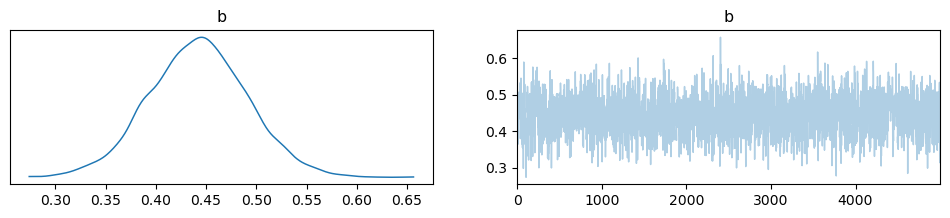

In [10]:
az.plot_trace(mcmc);

Finally, let's compare to our analytical result for the posterior distribution.

In [11]:
import seaborn as sns

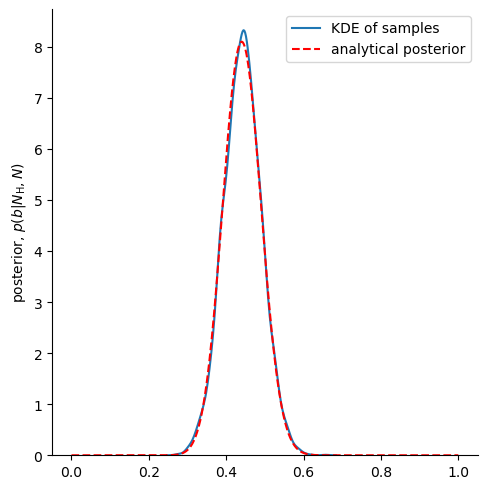

In [16]:
samples = mcmc.get_samples()
sns.displot(samples['b'], kind='kde', label='KDE of samples')
bs = jnp.linspace(0, 1, 500)
plt.plot(bs, jnp.exp(dist.Beta(1+n_heads, 1+nflips-n_heads).log_prob(bs)), color='r', ls='--', label='analytical posterior')
plt.ylabel(r'posterior, $p(b|N_\text{H},N)$')
plt.legend();